In [1]:
import holidays
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
np.random.seed(0)
us_holidays = holidays.UnitedStates()

In [2]:
#pip install holidays

# Generate customer IDs

In [3]:
def setage(age):
    '''
    function to limit the age between 18 and 65.
    if age is 16, it will be updated to 18 + abs(18-16)
    if age is 68, it will be updated to 65 - abs(65-68)
    '''
    if (age < 18):
        age = 18 + abs(18-age)
    if (age > 65):
        age = 65 - abs(65-age)
    return (age)

# test function 
print (setage(35))
print (setage(16))
print (setage(68))

35
20
62


In [4]:
def gencustID(startID = '100000'):
    '''
    function to generate customer ID, gender and age for each customer
    gender distribution: women: 40% and men 60%
    age distribution: women: mean 33, sd 10; men: mean 40 and sd 10
    customer ID: differs from previous customer ID by a random int between 3 and 13
    '''
    # get gender & age
    # if male, mean age is 40,
    # if female, mean age is 33
    if (np.random.random() < 0.4):
        G = 'F'
        age = int(np.random.normal(33, 10)) 
    else:
        G = 'M'
        age = int(np.random.normal(40, 10))
        
    # correct age for outliers
    age = setage(age)
        
    add  = np.random.randint(3, 13)
    custID = str(int(startID) + add)
                
    return (custID, G, age)

# test function
print (gencustID())

('100006', 'M', 47)


## Loop to generate customer IDs

In [5]:
# Loop to generate customer ids
nids = 5000  # no of customer IDs
cid = 100000 # starting ID
clist = [] # list to collect the data

# loop to generate
for i in range(nids):
    cid, g, age = gencustID(cid)
    clist.append((cid, g, age))
    
# convert this to data frame    
cldf = pd.DataFrame(clist)
cldf.columns = ['Customer ID', 'Gender', 'Age']
cldf.head()

,Customer ID,Gender,Age
0,100006,M,55
1,100017,M,49
2,100021,F,31
3,100029,M,65
4,100040,M,50


In [6]:
cldf.to_csv('CustomerTable.csv', index=False)

In [7]:
cldf.Gender.value_counts()

Gender
M    2987
F    2013
Name: count, dtype: int64

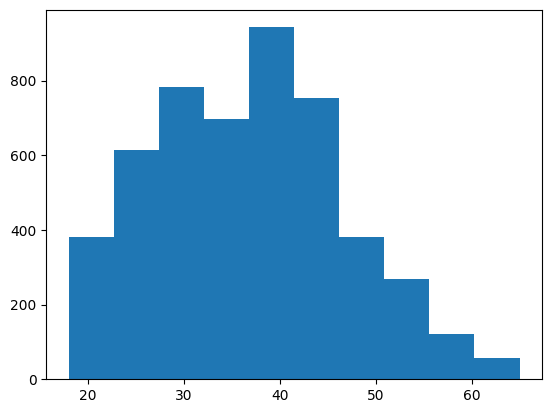

In [8]:
plt.hist(cldf.Age)
plt.show()

## Analysis of generated data

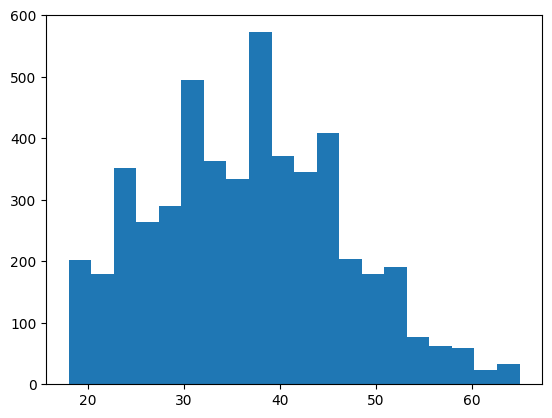

In [9]:
plt.hist(cldf['Age'], bins=20)
plt.show()

# Generate transactions

In [10]:
def dateupdate(date):
  '''
  function to update date and time 
  if visit time is beyond 10 pm in the night, 
  it is moved to next date after 5 am, by adding 7 hours
  '''
  if (int(str(date)[11:13]) >= 22):
      date = date + np.timedelta64(7, 'h')
  return (date)

print (dateupdate(np.datetime64('2021-01-01T11:33:24')))
print (dateupdate(np.datetime64('2021-01-01T23:45:00')))

2021-01-01T11:33:24
2021-01-02T06:45:00


In [11]:
def genrecord(cidlist, time = np.datetime64('2024-09-01T06:00:00')):
  '''
  generate one new record of visit, based on customer id list, 
  and start time provided
  ad is chosen randomly from among the 5 ads
  '''

  #get customer ID
  cid = np.random.choice(cidlist)
  
  #pick a time
  delta = np.random.randint(25, 500)
  time = time + np.timedelta64(delta, 's')
  
  # update time
  #move to next date if time exceeds 10pm
  time = dateupdate(time)
  
  # choose an ad id
  adid = np.random.randint(1, 6)

  return (cid, time, adid)

# test function
print (genrecord(['100001']))

(np.str_('100001'), np.datetime64('2024-09-01T06:04:48'), 4)


In [12]:
cidlist = list(cldf['Customer ID'])
print (len(cidlist))

5000


## Loop to generate transaction data

In [13]:
newdate = np.datetime64('2024-09-01T07:00:00')
print ('starting date is: ', newdate)
reclist = []
nrec = 100000  # no of records needed


for i in range(nrec):
    cid, newdate, adid = genrecord(cidlist, newdate)
    #print (cid, newdate, adid)
    
    #move to next date if time exceeds 10pm
    #newdate = dateupdate(newdate)
    
    reclist.append((cid, newdate, adid))
    
recdf = pd.DataFrame(reclist)
recdf.columns = ['Customer ID', 'Date Time', 'Ad ID']   
recdf.head() 

starting date is:  2024-09-01T07:00:00


,Customer ID,Date Time,Ad ID
0,104474,2024-09-01 07:07:24,4
1,129899,2024-09-01 07:10:42,5
2,121047,2024-09-01 07:15:12,3
3,133576,2024-09-01 07:20:03,2
4,112276,2024-09-01 07:20:52,4


In [14]:
recdf.tail()

,Customer ID,Date Time,Ad ID
99995,126848,2025-11-02 20:49:06,1
99996,107671,2025-11-02 20:52:03,1
99997,102485,2025-11-02 20:55:26,1
99998,128845,2025-11-02 21:03:41,2
99999,118865,2025-11-02 21:10:24,4


In [15]:
recdf.to_csv('TransactionList.csv', index=False)

In [16]:
recdf['Date Time'].describe()

count                           100000
mean     2025-04-03 08:07:01.071529728
min                2024-09-01 07:07:24
25%      2024-12-17 09:29:07.750000128
50%         2025-04-03 14:38:01.500000
75%         2025-07-19 08:23:52.500000
max                2025-11-02 21:10:24
Name: Date Time, dtype: object

# Combine Customer ID and transaction data to augment information

In [17]:
# add conversion rates to recdf
recdf['Customer ID'] = recdf['Customer ID'].astype(int)
cldf['Customer ID'] = cldf['Customer ID'].astype(int)

In [18]:
# merge both data sets, to add gender and age to transaction ID 
df = recdf.join(cldf.set_index('Customer ID'), how= 'left', on='Customer ID')

In [19]:
df.to_csv('TxnDB.csv')

In [20]:
df.head()

,Customer ID,Date Time,Ad ID,Gender,Age
0,104474,2024-09-01 07:07:24,4,M,40
1,129899,2024-09-01 07:10:42,5,M,20
2,121047,2024-09-01 07:15:12,3,M,50
3,133576,2024-09-01 07:20:03,2,M,47
4,112276,2024-09-01 07:20:52,4,M,45


In [21]:
# read data again to process

In [22]:
df = pd.read_csv('TxnDB.csv', index_col=0)

In [23]:
df.head()

,Customer ID,Date Time,Ad ID,Gender,Age
0,104474,2024-09-01 07:07:24,4,M,40
1,129899,2024-09-01 07:10:42,5,M,20
2,121047,2024-09-01 07:15:12,3,M,50
3,133576,2024-09-01 07:20:03,2,M,47
4,112276,2024-09-01 07:20:52,4,M,45


## Add holidays to the dates in the transaction table

In [24]:
df['Holiday'] = df['Date Time'].apply(lambda x: us_holidays.get(str(x)[:10]))
df.head()

,Customer ID,Date Time,Ad ID,Gender,Age,Holiday
0,104474,2024-09-01 07:07:24,4,M,40,None
1,129899,2024-09-01 07:10:42,5,M,20,None
2,121047,2024-09-01 07:15:12,3,M,50,None
3,133576,2024-09-01 07:20:03,2,M,47,None
4,112276,2024-09-01 07:20:52,4,M,45,None


In [25]:
df['Holiday'].unique()

array([None, 'Labor Day', 'Columbus Day', 'Veterans Day',
       'Thanksgiving Day', 'Christmas Day', "New Year's Day",
       'Martin Luther King Jr. Day', "Washington's Birthday",
       'Memorial Day', 'Juneteenth National Independence Day',
       'Independence Day'], dtype=object)

## Add Weekday/weekend info to the dates in the transaction table. Working is weekday

In [26]:
df['Working'] = df['Date Time'].apply(lambda x: np.is_busday(str(x)[:10]))

In [27]:
df.head()

,Customer ID,Date Time,Ad ID,Gender,Age,Holiday,Working
0,104474,2024-09-01 07:07:24,4,M,40,None,False
1,129899,2024-09-01 07:10:42,5,M,20,None,False
2,121047,2024-09-01 07:15:12,3,M,50,None,False
3,133576,2024-09-01 07:20:03,2,M,47,None,False
4,112276,2024-09-01 07:20:52,4,M,45,None,False


In [28]:
df['Working'].unique()

array([False,  True])

## Get conversion probabilites for different ads from different age groups

In [29]:
def getconvprobs(row, change_date = '2025-04-01'):
  '''
  THIS FUNCTION SIMULATES THE ACTUAL WORLD
  normal probability is between 0 and 0.2
  for some gender-age-ad combinations, the probability is higher
  
  ''' 

  date = str(row['Date Time'])[:10]
  probs = 0.2 * np.random.random()
  
  # set specific conditions
  # Ad 1 is liked by young men, with a conversion rate of 0.8
  if ((row['Ad ID'] == 1) & (row['Gender'] == 'M') & (row['Age'] < 40)):
      probs = 0.82
      if (date > change_date):
        probs = 0.2

  # Ad 2 is liked by young women, with a conversion rate of 0.7
  if ((row['Ad ID'] == 2) & (row['Gender'] == 'F') & (row['Age'] < 37)):
      probs = 0.73
  
  # Ad 3 is liked by old people , with a conversion rate of 0.7
  if ((row['Ad ID'] == 3) & (row['Age'] > 50)):
      probs = 0.67
      
  # Ad 4 is liked by people from 40 to 50 years of age 
  if ((row['Ad ID'] == 4) & (row['Age'] >= 40) & (row['Age'] <= 50)):
      probs = 0.54

  if ((row['Ad ID'] == 5) & (row['Gender'] == 'M') & (row['Age'] < 40)):
      probs = 0.12
      if (date > change_date):
        probs = 0.72

  if (row['Working'] == 'False'):
      probs += 0.05
      
  if (row['Holiday'] != None):
      probs += 0.1
      
  probs += 0.005 * abs(row['Age'] - 35) - 0.1
        
  return (max(round(probs, 2), 0))

In [30]:
def convprobstest(row, date = '2025-04-01'):
    date = str(row['Date Time'])[:10]
    probs = 0.05 * np.random.random()
    
    if (date < '2020-04-01'):
      if (row['Ad ID'] == 1):
        probs = 0.3
      elif (row['Ad ID'] == 2):
        probs = 0.2
    else:
      if (row['Ad ID'] == 2):
        probs = 0.4
    return (round(probs, 2))

In [31]:
def click(probs):
  '''
  set the ad as clicked or not, based on the probability
  '''
  if (np.random.random() < probs):
      return 1
  else:
      return 0

In [32]:
# Create probabilities 
# Simple function to test
# df['probs'] = df.apply(convprobstest, axis=1)


# Actual function for data
df['probs'] = df.apply(getconvprobs, axis=1)

In [33]:
df.head()

,Customer ID,Date Time,Ad ID,Gender,Age,Holiday,Working,probs
0,104474,2024-09-01 07:07:24,4,M,40,None,False,0.47
1,129899,2024-09-01 07:10:42,5,M,20,None,False,0.09
2,121047,2024-09-01 07:15:12,3,M,50,None,False,0.10
3,133576,2024-09-01 07:20:03,2,M,47,None,False,0.13
4,112276,2024-09-01 07:20:52,4,M,45,None,False,0.49


In [34]:
df['click'] = df['probs'].apply(lambda x: click(x))

In [35]:
df.head()

,Customer ID,Date Time,Ad ID,Gender,Age,Holiday,Working,probs,click
0,104474,2024-09-01 07:07:24,4,M,40,None,False,0.47,1
1,129899,2024-09-01 07:10:42,5,M,20,None,False,0.09,1
2,121047,2024-09-01 07:15:12,3,M,50,None,False,0.10,0
3,133576,2024-09-01 07:20:03,2,M,47,None,False,0.13,0
4,112276,2024-09-01 07:20:52,4,M,45,None,False,0.49,0


In [36]:
a = np.datetime64('2020-01-01T07:04:16')
print (a)

2020-01-01T07:04:16


In [37]:
str(a)[:10]

'2020-01-01'

In [38]:
print ('total number of records:', len(df))
print ('number of clicks:',  df['click'].sum())

total number of records: 100000
number of clicks: 16480


In [39]:
df.to_csv('AdClickInfo.csv', index=False)

In [40]:
df['click'].value_counts()

click
0    83520
1    16480
Name: count, dtype: int64